# Setup

In [1]:
# Load necessary libraries
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from pandas.plotting import register_matplotlib_converters
import time
import joblib

%matplotlib inline
%config InlineBackend.figure_formats = set(['svg'])

register_matplotlib_converters()
# can add font_scale=1.5 if necessary
sns.set(style='whitegrid', palette='muted')

# plt.style.use('seaborn')
# NOTE: rcParams need to be after style.use
plt.rcParams["figure.figsize"] = (15, 10)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting some visualization parameters
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
df = pd.read_csv('data//cleaned_df.csv')
df.head()

,price,year,odometer,lat,long,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color
0,9500,2003.0,30376.0,32.614209,-85.326357,chrysler,excellent,6,gas,clean,automatic,fwd,other,blue
1,28990,2018.0,20736.0,32.590000,-85.480000,gmc,good,6,gas,clean,other,fwd,other,white
2,16590,2013.0,61087.0,32.590000,-85.480000,lincoln,good,unknown,gas,clean,other,fwd,sedan,red
3,28990,2017.0,18041.0,32.590000,-85.480000,gmc,good,6,gas,clean,other,fwd,other,unknown
4,20590,2017.0,36436.0,32.590000,-85.480000,lincoln,good,unknown,gas,clean,other,fwd,sedan,unknown


In [12]:
df.dtypes

price             int64
year            float64
odometer        float64
lat             float64
long            float64
manufacturer     object
condition        object
cylinders        object
fuel             object
title_status     object
transmission     object
drive            object
type             object
paint_color      object
dtype: object

In [13]:
df.isna().sum()

price              0
year             699
odometer        1655
lat             3608
long            3608
manufacturer       0
condition          0
cylinders          0
fuel               0
title_status       0
transmission       0
drive              0
type               0
paint_color        0
dtype: int64

# Extra Feature Engineering

In [4]:
df_copy = df.copy()

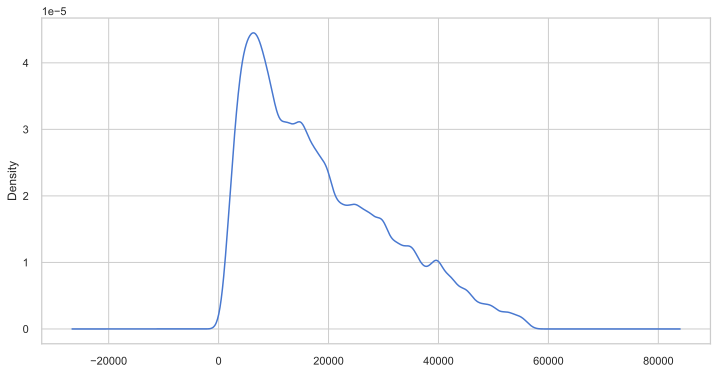

In [187]:
df_copy.price.plot(kind='kde', figsize=(12, 6))
plt.show()

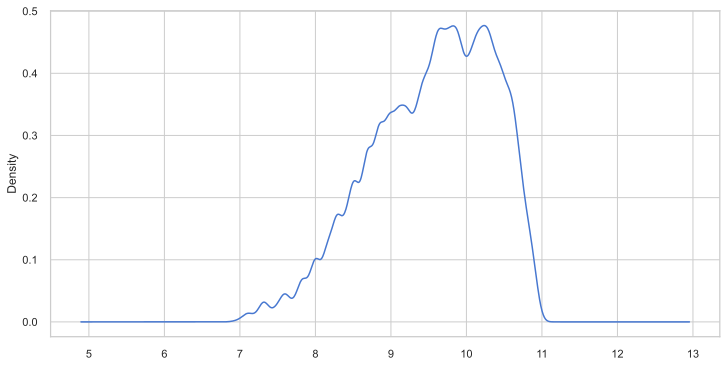

In [188]:
np.log(df_copy['price']).plot(kind='kde', figsize=(12, 6))
plt.show()

In [268]:
# Log price distribution looks better
df_copy['log_price'] = np.log(df_copy.pop('price'))

In [269]:
df_copy.head()

,year,odometer,lat,long,manufacturer,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,log_price
0,2003.0,30376.0,32.614209,-85.326357,chrysler,excellent,6,gas,clean,automatic,fwd,other,blue,9.159047
1,2018.0,20736.0,32.590000,-85.480000,gmc,good,6,gas,clean,other,fwd,other,white,10.274706
2,2013.0,61087.0,32.590000,-85.480000,lincoln,good,unknown,gas,clean,other,fwd,sedan,red,9.716555
3,2017.0,18041.0,32.590000,-85.480000,gmc,good,6,gas,clean,other,fwd,other,unknown,10.274706
4,2017.0,36436.0,32.590000,-85.480000,lincoln,good,unknown,gas,clean,other,fwd,sedan,unknown,9.932561


# Pipeline

In [9]:
np.random.seed(42)

In [5]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=None, test_size=None,
    stratify=None, random_state=42, shuffle=True
):
    if not val_size:
        val_size = (1 - train_size) / 2.
        test_size = val_size
        
    assert int(train_size + val_size + test_size + 1e-7) == 1
    
    stratify_1 = y if stratify else None
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=stratify_1, 
        random_state=random_state, shuffle=shuffle)
    
    stratify_2 = y_train_val if stratify else None
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, stratify=stratify_2, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
# target = 'log_price'
target = 'price'

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X=df_copy.drop(columns=target),
                                                                             y=df_copy[target],
                                                                             train_size=0.80)

In [8]:
X_train.shape, y_train.shape, y_val.shape, y_test.shape

((264320, 13), (264320,), (33040,), (33041,))

In [20]:
X_train.dtypes

year            float64
odometer        float64
lat             float64
long            float64
manufacturer     object
condition        object
cylinders        object
fuel             object
title_status     object
transmission     object
drive            object
type             object
paint_color      object
dtype: object

In [21]:
df_copy.isna().sum()

price              0
year             699
odometer        1655
lat             3608
long            3608
manufacturer       0
condition          0
cylinders          0
fuel               0
title_status       0
transmission       0
drive              0
type               0
paint_color        0
dtype: int64

In [22]:
cats = list(df_copy.select_dtypes(exclude=['float64', 'int64']).columns)
nums = list(df_copy.select_dtypes(include=['float64', 'int64']).columns)
# remove the target variable
nums.remove(target)
print(f'Categorical variables:  {cats}')
print(f'Numerical variables:  {nums}')

Categorical variables:  ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
Numerical variables:  ['year', 'odometer', 'lat', 'long']


In [23]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestRegressor

oneHotCat_trans = make_column_transformer(
    # OneHotEncoder auto encode nan values under the hood
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), cats),
    # ('scaler', RobustScaler(with_centering=False), nums),
    # ('std_scaler_age', StandardScaler(with_mean=False), ['age']),
    # ('imputer', KNNImputer(n_neighbors=5), missing_nums)
remainder="passthrough")

ordinalCat_trans = make_column_transformer(
    (OrdinalEncoder(), cats),
    # ('scaler', RobustScaler(with_centering=False), nums),
    # ('std_scaler_age', StandardScaler(with_mean=False), ['age']),
    # ('imputer', KNNImputer(n_neighbors=5), missing_nums)
remainder="passthrough")

cylinders_order = [['unknown', '4', '6', '8']]
cat_trans = make_column_transformer(
    (OrdinalEncoder(categories=cylinders_order), ['cylinders']),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), 
     np.delete(cats, cats.index('cylinders'))),
remainder='passthrough')

pipe_1 = make_pipeline(
    oneHotCat_trans,
    RobustScaler(with_centering=True),
    KNNImputer(n_neighbors=5),
)

pipe_2 = make_pipeline(
    ordinalCat_trans,
    RobustScaler(with_centering=True),
    KNNImputer(n_neighbors=2),
)

pipe_5 = make_pipeline(
    cat_trans,
    RobustScaler(with_centering=True),
    KNNImputer(n_neighbors=2),
)

train_pipe_1 = make_pipeline(
    pipe_1,
    # ('select_kbest', SelectKBest(k=10)),
    # ('pca_2', PCA(n_components=2)),
    RandomForestRegressor(n_jobs=10, random_state=42)
)

train_pipe_2 = make_pipeline(
    pipe_2,
    RandomForestRegressor(n_jobs=10, random_state=42)
)

train_pipe_5 = make_pipeline(
    pipe_5,
    RandomForestRegressor(n_jobs=10, random_state=42)
)

In [31]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

mean_price = df.price.mean()

def eval_pred(predictions, y_true=y_val):
    R2 = r2_score(y_true, predictions)
    RMSE = mse(y_true, predictions, squared=False)
    MAE = mae(y_true, predictions)
    print(f"Mean Price\t:\t{mean_price}")
    print(f"RMSE\t\t:\t{RMSE}")
    print(f"MAE\t\t:\t{MAE}")
    print()
    print(f"R2\t\t:\t{R2}")

## Train

In [26]:
start_time = time.time()
train_pipe_1.fit(X_train, y_train)
print(time.time() - start_time)

276.5823767185211


In [38]:
pred_1 = train_pipe_1.predict(X_val)

In [39]:
# R2 = 0.9087
eval_pred(pred_1, y_true=y_val)

Mean Price	:	18378.823995690087
RMSE		:	3783.5744360231192
MAE		:	2023.1838493781004

R2		:	0.9087463228101137


In [43]:
# prediction on test set
pred_test_1 = train_pipe_1.predict(X_test)

In [44]:
# evaluation on test set
eval_pred(pred_test_1, y_true=y_test)

Mean Price	:	18378.823995690087
RMSE		:	3766.103619034398
MAE		:	2017.855676959216

R2		:	0.9092923082292013


In [33]:
# model = joblib.load('model_1.joblib')
# pred = model.predict(X_val)

In [ ]:
# eval_pred(pred, y_true=y_val)

In [290]:
start_time = time.time()
train_pipe_5.fit(X_train, y_train)
print(time.time() - start_time)

243.28349900245667


In [291]:
pred_5 = train_pipe_5.predict(X_val)

In [293]:
eval_pred(np.exp(pred_5), y_true=np.exp(y_val))

Mean Price	:	18378.823995690087
RMSE		:	3860.238053423925
MAE		:	1995.6563819729706

R2		:	0.9050108537673158


In [ ]:
# NAN values in 'condition' causes mismatch of lengths of columns

In [297]:
onehot_cols = list(pd.get_dummies(X_train.dropna(subset=['year', 'odometer', 'lat', 'long'])).columns)
len(onehot_cols)

87

In [298]:
# NAN VALUE IN CONDITION !! THEREFORE DIFFERENT LENGTHS

In [299]:
# rearrange the column names to align properly
cols_to_rotate = nums
for col in cols_to_rotate:
    onehot_cols.remove(col)
    onehot_cols.append(col)    

In [300]:
model = train_pipe_1.named_steps['randomforestregressor']
feature_importance = model.feature_importances_
feature_importance = pd.Series(feature_importance, index=onehot_cols)

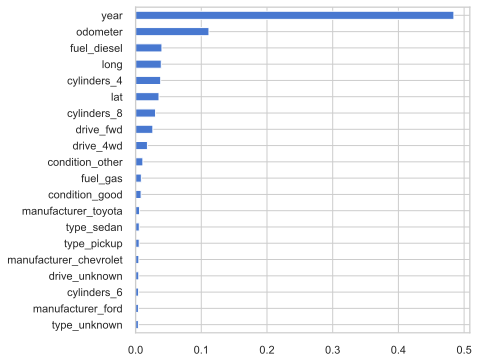

In [301]:
feature_importance.nlargest(20).sort_values().plot(kind='barh', figsize=(6, 6))
plt.show()

## Save model

In [49]:
X_train_tf = pipe_1.fit_transform(X_train)
X_val_tf = pipe_1.transform(X_val)

In [110]:
# to separate model from transformation pipeline
# use lower max_depth to reduce memory
# https://mljar.com/blog/random-forest-memory/
model = RandomForestRegressor(max_depth=16, n_jobs=10, random_state=42)
model.fit(X_train_tf, y_train)

RandomForestRegressor(max_depth=16, n_jobs=10, random_state=42)

In [111]:
# to reduce memory
# https://mljar.com/blog/random-forest-memory/
depths = [tree.tree_.max_depth for tree in model.estimators_]
print(f"Mean tree depth in the Random Forest: {np.round(np.mean(depths))}")

Mean tree depth in the Random Forest: 16.0


In [112]:
pred = model.predict(X_val_tf)

In [113]:
eval_pred(pred, y_true=y_val)

Mean Price	:	18378.823995690087
RMSE		:	4689.595048365856
MAE		:	3029.5074745080615

R2		:	0.8598101748428556


In [114]:
# 44 MB with max_depth=16, n_jobs=10
joblib.dump(model, 'model_rfr.joblib', compress=('zlib'))

['model_rfr.joblib']

### Try pipeline

In [115]:
train_pipe = make_pipeline(
    pipe_1,
    RandomForestRegressor(max_depth=16, n_jobs=10, random_state=42)
)

In [116]:
train_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['manufacturer',
                                                                    'condition',
                                                                    'cylinders',
                                                                    'fuel',
                                                                    'title_status',
                                                                    'transmission',
                                                               

In [117]:
pred_pipe = train_pipe.predict(X_val)

In [118]:
eval_pred(pred_pipe, y_true=y_val)

Mean Price	:	18378.823995690087
RMSE		:	4689.595048365856
MAE		:	3029.5074745080615

R2		:	0.8598101748428556


In [119]:
# 56 MB with max_depth=16, n_jobs=10
joblib.dump(train_pipe, 'model_pipe.joblib', compress=('zlib'))

['model_pipe.joblib']

## Train with Ordinal Encoder

In [278]:
start_time = time.time()
train_pipe_2.fit(X_train, y_train)
end_time = time.time() - start_time
print(end_time - start_time)

Wall time: 0 ns


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ordinalencoder',
                                                                   OrdinalEncoder(),
                                                                   ['manufacturer',
                                                                    'condition',
                                                                    'fuel',
                                                                    'title_status',
                                                                    'transmission',
                                                                    'drive',
                                                                    'type',
                                                                    'paint_color'])])),
                   

In [336]:
pred_2 = train_pipe_2.predict(X_val)

In [337]:
eval_pred(pred_2)

Mean Price	:	17735.42552557763
RMSE		:	4541.357542410136
MAE		:	2460.3756813809932

R2		:	0.872021304698759


In [282]:
model = train_pipe_2.named_steps['randomforestregressor']
feature_importance = model.feature_importances_
feature_importance = pd.Series(feature_importance, index=X_train.columns.values)

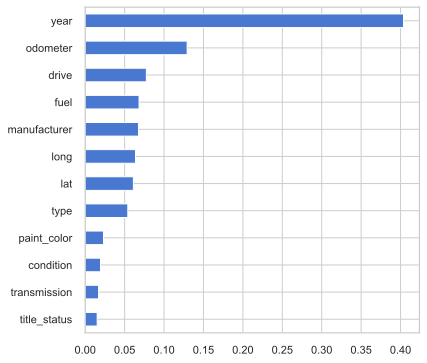

In [284]:
feature_importance.sort_values().plot(kind='barh', figsize=(6, 6))
plt.show()

# Dropna for the numerical features

In [367]:
df_copy = df.copy()

In [371]:
df.isna().sum()

manufacturer       0
condition          0
fuel               0
title_status       0
transmission       0
drive              0
type               0
paint_color        0
price              0
year             710
odometer        1778
lat             3658
long            3658
dtype: int64

In [368]:
df_copy.dropna(inplace=True)

In [341]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X=df_copy.drop(columns='price'),
                                                                             y=df_copy.price,
                                                                             train_size=0.80)

In [292]:
X_train.shape, y_train.shape, y_val.shape, y_test.shape

((271800, 12), (271800,), (33975,), (33975,))

In [293]:
pipe_3 = make_pipeline(
    oneHotCat_trans,
    RobustScaler(with_centering=True),
)

train_pipe_3 = make_pipeline(
    pipe_3,
    RandomForestRegressor(random_state=42)
)

In [295]:
start_time = time.time()
train_pipe_3.fit(X_train, y_train)
print(time.time() - start_time)

324.0459694862366


In [342]:
pred_3 = train_pipe_3.predict(X_val)

In [343]:
eval_pred(pred_3)

Mean Price	:	17735.42552557763
RMSE		:	4504.3356586475265
MAE		:	2414.9503397515323

R2		:	0.873684660814579


In [299]:
model = train_pipe_3.named_steps['randomforestregressor']
feature_importance = model.feature_importances_
feature_importance = pd.Series(feature_importance, index=onehot_cols)

In [312]:
len(onehot_cols)

85

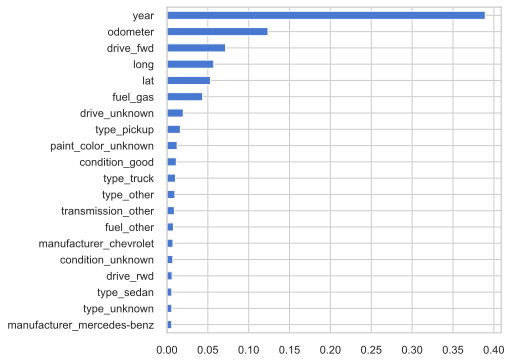

In [300]:
feature_importance.nlargest(20).sort_values().plot(kind='barh', figsize=(6, 6))
plt.show()

In [310]:
df.columns.values

array(['manufacturer', 'condition', 'fuel', 'title_status',
       'transmission', 'drive', 'type', 'paint_color', 'price', 'year',
       'odometer', 'lat', 'long'], dtype=object)

# Drop some features

In [349]:
df_copy = df.copy()

In [350]:
df_copy.dropna(inplace=True)

In [351]:
feat_to_drop = ['paint_color', 'condition', 'transmission', 'title_status']

In [352]:
df_copy.drop(columns=feat_to_drop, inplace=True)

In [353]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X=df_copy.drop(columns='price'),
                                                                             y=df_copy.price,
                                                                             train_size=0.80)

In [357]:
cats = list(df_copy.select_dtypes(exclude=['float64']).columns)
nums = list(df_copy.select_dtypes(include=['float64']).columns)
nums.remove('price')
print(f'Categorical variables:  {cats}')
print(f'Numerical variables:  {nums}')

Categorical variables:  ['manufacturer', 'fuel', 'drive', 'type']
Numerical variables:  ['year', 'odometer', 'lat', 'long']


In [359]:
X_train.columns

Index(['manufacturer', 'fuel', 'drive', 'type', 'year', 'odometer', 'lat',
       'long'],
      dtype='object')

In [363]:
oneHotCat_trans = make_column_transformer(
    (OneHotEncoder(drop='first', sparse=False), cats),
remainder="passthrough")

pipe_4 = make_pipeline(
    oneHotCat_trans,
    RobustScaler(with_centering=True),
)

train_pipe_4 = make_pipeline(
    pipe_3,
    RandomForestRegressor(random_state=42)
)

In [364]:
start_time = time.time()
train_pipe_4.fit(X_train, y_train)
print(time.time() - start_time)

239.3090250492096


In [365]:
pred_4 = train_pipe_3.predict(X_val)

In [366]:
eval_pred(pred_4)

Mean Price	:	17735.42552557763
RMSE		:	4796.979044142108
MAE		:	2600.281785620078

R2		:	0.8567382530921874
